In [1]:
%matplotlib inline
import numpy as np                  
import matplotlib.pyplot as plt     
import random   
import math
from tqdm import tqdm


from keras.datasets import mnist    
from keras.models import Sequential 

#from keras.layers.core import Dense, Dropout, Activation 
#from keras.utils import np_utils  

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split

import matplotlib.image as mpimg
import scipy.ndimage as ndi

from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
import keras

from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from numba import jit
pi = math.pi

import random
#from cv2 import cv2
import cv2
import scipy.stats
import seaborn as sns

from nexusformat.nexus import *
from matplotlib.patches import Circle



# Loading in Data

In [14]:
# Load your numpy arrays
x_train = np.load('x_train_12L_100k.npy')
x_test = np.load('x_test_12L_100k.npy')

y_train_real = np.load('y_train_real_12L_100k.npy')
y_test_real = np.load('y_test_real_12L_100k.npy') 

y_train_imag = np.load('y_train_imag_12L_100k.npy')
y_test_imag = np.load('y_test_imag_12L_100k.npy')

#mean, std arrays for transformation
means_real = np.load("means_real_12L_100k.npy")
std_real = np.load("std_real_12L_100k.npy")

means_imag = np.load("means_imag_12L_100k.npy")
std_imag = np.load("std_imag_12L_100k.npy")

#atomic positions
all_cns = np.load("all_cns_12L_100k.npy")
all_o1s = np.load("all_o1s_12L_100k.npy")
all_o2s = np.load("all_o2s_12L_100k.npy")
all_o3s = np.load("all_o3s_12L_100k.npy")
all_Tis = np.load("all_Tis_12L_100k.npy")
all_ps = np.load("all_ps_12L_100k.npy")


#Split into Train and Validation
train_size = len(x_train)
train_val_split_size = int(0.9 * len(x_train))
x_train_split = x_train[0:train_val_split_size]
y_train_real_split = y_train_real[0:train_val_split_size]
y_train_imag_split =  y_train_imag[0:train_val_split_size]

x_val = x_train[train_val_split_size:]
y_val_real = y_train_real[train_val_split_size:]
y_val_imag =  y_train_imag[train_val_split_size:]


# Create TensorFlow datasets
train_dataset_real = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_real_split))
val_dataset_real = tf.data.Dataset.from_tensor_slices((x_val, y_val_real))

train_dataset_imag = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_imag_split))
val_dataset_imag = tf.data.Dataset.from_tensor_slices((x_val, y_val_imag))

# Define batch size
batch_size = 32

# Satch the training dataset
train_dataset_real = train_dataset_real.batch(batch_size)
train_dataset_imag = train_dataset_imag.batch(batch_size)


# Batch the validation dataset
val_dataset_real = val_dataset_real.batch(batch_size)
val_dataset_imag = val_dataset_imag.batch(batch_size)

2024-07-27 00:21:53.534575: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-07-27 00:21:53.536412: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-07-27 00:21:53.536416: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-07-27 00:21:53.536948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-27 00:21:53.538295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Building the UNet

In [15]:
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Concatenate


In [16]:
#custom Loss
#see if theres infinite loss type thing
def custom_loss(y_true, y_pred):
    diff = y_true - y_pred
    val = (diff + pi) % (2*pi) - pi
    
    return tf.reduce_mean(tf.abs(val))


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Concatenate, BatchNormalization

def unet_1d(input_shape):
    inputs = Input(input_shape)

    # Encoding path
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv1D(128, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(256, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv1D(256, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    # Center path
    conv3 = Conv1D(512, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv1D(512, 3, activation='relu', padding='same')(conv3)

    # Decoding path
    up4 = Conv1D(256, 2, activation='relu', padding='same')(UpSampling1D(size=2)(conv3))
    merge4 = Concatenate(axis=-1)([conv2, up4])
    conv4 = Conv1D(256, 3, activation='relu', padding='same')(merge4)
    conv4 = Conv1D(256, 3, activation='relu', padding='same')(conv4)

    up5 = Conv1D(128, 2, activation='relu', padding='same')(UpSampling1D(size=2)(conv4))
    merge5 = Concatenate(axis=-1)([conv1, up5])
    conv5 = Conv1D(128, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv1D(128, 3, activation='relu', padding='same')(conv5)

    outputs = Conv1D(1, 1, activation='linear', padding='same')(conv5)

    model = Model(inputs, outputs)
    return model

x_new_times_y_new = x_test[0].shape[0]
# Define input shape (476, 1)
input_shape = (x_new_times_y_new, 1)

# Create the modified model
model = unet_1d(input_shape)

# Print the modified model summary
model.summary()
tf.random.set_seed(40)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3840, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 3840, 128)            512       ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 3840, 128)            49280     ['conv1d[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 1920, 128)            0         ['conv1d_1[0][0]']            
 D)                                                                                           

# E_real

Epoch 1/30


2024-07-27 00:24:01.313716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - ETA: 0s - loss: 0.2836 - mean_absolute_error: 0.2836

2024-07-27 00:50:52.825016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.21091, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1656s 576ms/step - loss: 0.2836 - mean_absolute_error: 0.2836 - val_loss: 0.2109 - val_mean_absolute_error: 0.2109
Epoch 2/30


/Users/pranavkakhandiki/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2813/2813 [==============================] - ETA: 0s - loss: 0.1932 - mean_absolute_error: 0.1932
Epoch 2: val_loss improved from 0.21091 to 0.17990, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1447s 514ms/step - loss: 0.1932 - mean_absolute_error: 0.1932 - val_loss: 0.1799 - val_mean_absolute_error: 0.1799
Epoch 3/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1725 - mean_absolute_error: 0.1725
Epoch 3: val_loss improved from 0.17990 to 0.16491, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1472s 523ms/step - loss: 0.1725 - mean_absolute_error: 0.1725 - val_loss: 0.1649 - val_mean_absolute_error: 0.1649
Epoch 4/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1610 - mean_absolute_error: 0.1610
Epoch 4: val_loss improved from 0.16491 to 0.15410, saving model to unet_12L_100k_30e_real.h5
2813/2813 [==============================] - 1492s 530ms/step - loss: 0.1610 - mea

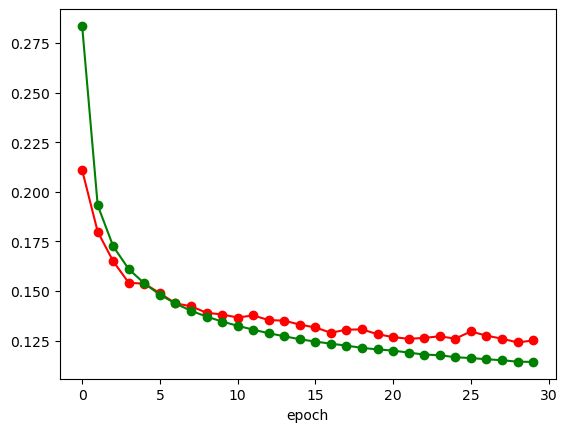

In [18]:
model = unet_1d(input_shape)

with tf.device('/device:CPU:0'):
    model.compile(loss = 'mean_absolute_error',
                 optimizer = "adam",
                 metrics = ['mean_absolute_error'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_12L_100k_30e_real.h5', verbose=1, save_best_only=True)
callbacks = [
    checkpointer
]

# Train your model using the dataset
results = model.fit(train_dataset_real, epochs=30, validation_data=val_dataset_real, callbacks=callbacks)

plt.plot(results.history['val_loss'], 'o-', color = 'red')
plt.plot(results.history['loss'], 'o-', color = 'green')
plt.xlabel('epoch')

np.save("trainLoss_12L_100k_real.npy", results.history['loss'])
np.save("valLoss_12L_100k_real.npy", results.history['val_loss'])

In [19]:
model_new = unet_1d(input_shape)
model_new.load_weights('unet_12L_100k_30e_real.h5')

# Now you can use the model to make predictions

predictions_real = model_new.predict([x_test])
#predictions_train_real = model_new.predict([x_train])

2024-07-27 13:02:40.304110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 6s 150ms/step


# E_imag

Epoch 1/30


2024-07-27 13:02:49.015966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2813/2813 [==============================] - ETA: 0s - loss: 0.2815 - mean_absolute_error: 0.2815

2024-07-27 13:27:53.972516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.21606, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1547s 537ms/step - loss: 0.2815 - mean_absolute_error: 0.2815 - val_loss: 0.2161 - val_mean_absolute_error: 0.2161
Epoch 2/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1920 - mean_absolute_error: 0.1920
Epoch 2: val_loss improved from 0.21606 to 0.17727, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1468s 522ms/step - loss: 0.1920 - mean_absolute_error: 0.1920 - val_loss: 0.1773 - val_mean_absolute_error: 0.1773
Epoch 3/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1714 - mean_absolute_error: 0.1714
Epoch 3: val_loss improved from 0.17727 to 0.16706, saving model to unet_12L_100k_30e_imag.h5
2813/2813 [==============================] - 1489s 529ms/step - loss: 0.1714 - mean_absolute_error: 0.1714 - val_loss: 0.1671 - val_mean_absolute_error: 0.1671
Epoch 4/30
2813/2813 [=

2813/2813 [==============================] - 1536s 546ms/step - loss: 0.1175 - mean_absolute_error: 0.1175 - val_loss: 0.1249 - val_mean_absolute_error: 0.1249
Epoch 25/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1167 - mean_absolute_error: 0.1167
Epoch 25: val_loss did not improve from 0.12465
2813/2813 [==============================] - 1553s 552ms/step - loss: 0.1167 - mean_absolute_error: 0.1167 - val_loss: 0.1274 - val_mean_absolute_error: 0.1274
Epoch 26/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1160 - mean_absolute_error: 0.1160
Epoch 26: val_loss did not improve from 0.12465
2813/2813 [==============================] - 1694s 602ms/step - loss: 0.1160 - mean_absolute_error: 0.1160 - val_loss: 0.1247 - val_mean_absolute_error: 0.1247
Epoch 27/30
2813/2813 [==============================] - ETA: 0s - loss: 0.1157 - mean_absolute_error: 0.1157
Epoch 27: val_loss improved from 0.12465 to 0.12361, saving model to unet_12L_100k_30e_imag.h5

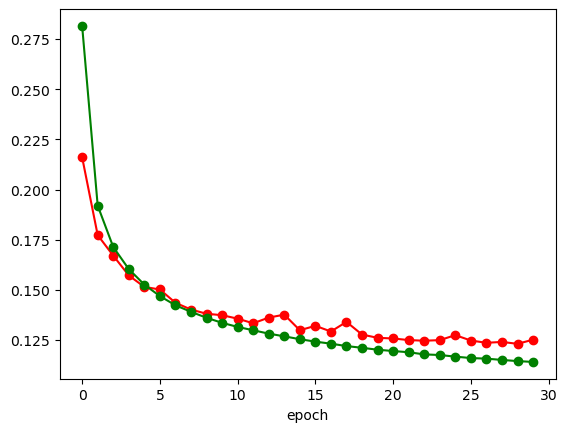

In [20]:
model = unet_1d(input_shape)

with tf.device('/device:CPU:0'):
    model.compile(loss = 'mean_absolute_error',
                 optimizer = "adam",
                 metrics = ['mean_absolute_error'])

checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_12L_100k_30e_imag.h5', verbose=1, save_best_only=True)
callbacks = [
    checkpointer
]

results = model.fit(train_dataset_imag, epochs=30, validation_data=val_dataset_imag, callbacks=callbacks)


plt.plot(results.history['val_loss'], 'o-', color = 'red')
plt.plot(results.history['loss'], 'o-', color = 'green')
plt.xlabel('epoch')

np.save("trainLoss_12L_100k_imag.npy", results.history['loss'])
np.save("valLoss_12L_100k_imag.npy", results.history['val_loss'])

In [21]:
model_new = unet_1d(input_shape)
model_new.load_weights('unet_12L_100k_30e_imag.h5')

predictions_imag = model_new.predict([x_test])
#predictions_train_imag = model_new.predict([x_train])

2024-07-28 01:52:56.877676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 7s 156ms/step


In [22]:
predictions_real = predictions_real.reshape((len(predictions_real), x_new_times_y_new))
y_test_real = y_test_real.reshape((len(y_test_real), x_new_times_y_new))

predictions_imag = predictions_imag.reshape((len(predictions_imag), x_new_times_y_new))
y_test_imag = y_test_imag.reshape((len(y_test_imag), x_new_times_y_new))

In [23]:
predictions_real.shape
len(predictions_real[0])

3840